In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Supercomputação - Projeto Final - Rafael Vieira Rosenzvaig
## O Problema

###### Este projeto tem como objetivo resolver o problema de escolha de projetos finais de engenharia dos alunos do Insper, utilizando técnicas de computação paralela.


###### Solução:
A solução encontrada, em um primeiro momento, foi a mais intutiva possível. No arquivo, busca_exaustiva_seq função escolhe_alunos() recebe a lista de preferências de cada aluno como entrada e recursivamente calcula a satisfação geral com todas as combinações possíveis. A combinação que possuir satisfação geral melhor será a escolhida e retornada pela função. Porém este método acaba tendo que realizar muitas operações desnecessárias para chegar ao resultado e também é pouco otimizado para entradas muito grandes.
Para tentar melhorar isso, foram implementadas técnicas de programação de busca local e busca local na gpu, com versões também paralelizadas (na versao processada na cpu) para melhorar o tempo de processamento e chegar no mesmo resultado que a solução mais ingênua do problema.

## Infraestrutura
##### Executáveis:
- busca_exasutiva_seq
- busca_exaustiva_par
- busca_local_seq
- busca_local_par
- busca_gpu
- backtrack.py
- cria_entrada.py

##### Arquivos:
- backtrack.py
    - Este arquivo define as funções: 
        - escolhe_alunos(), é a função que recursivamente calcula qual a melhor combinação possível entre a distribuição dos alunos, baseada na preferência de cada um.
        - main(), lê os parâmetros do arquivo de entrada e chama a função escolhe_alunos() com esses parâmetros.
- cria_entrada.py
    - Este arquivo cria uma entrada para o arquivo backtrack.py e/ou ingenua.cpp e dentro dela são definidos os parâmetros de número de alunos, número de projetos e número de escolhas que cada aluno pode fazer para ranquear sua preferência.
- CMakeLists.txt
    - Este arquivo contém os parâmetros de compilação para gerar o executável por meio do CMAKE.
- busca_exaustiva_seq
    - Este arquivo é a tradução direta para C++ do arquivo backtrack.py, portanto as funções fazem as mesmas coisas.
- busca_exaustiva_par
    - Este arquivo é a versão paralelizada do busca_exaustiva_seq. Ele cria tasks paralelizadas para fazer a recursão que também é feita no método sequencial. Este arquivo também possúi as versões com limitação do número de threads: busca_exaustiva_par_2t, busca_exaustiva_par_4t, busca_exaustiva_par_6t e busca_exaustiva_par_8t.
- busca_local_seq
    - Este arquivo realiza a técnica de busca local para identificar qual a melhor solução para o problema de alocação dos alunos nos projetos. Ele define as seguintes funções para isso:
        - A função main() lê o arquivo de entrada e realiza, 100.000 vezes, a verificação da melhor alternativa possível ao gerar um vetor aleatório, utilizando a função random_alunos_dist(), e tentar realizar trocas par a par para ver se há uma melhoria na satisfação, utilizando a função escolhe_alunos(). Além disso, existe a função calc_satisfacao_atual() que faz o cálculo da satisfação atual da distribuição dos alunos em um determinado ponto da iteração.
- busca_local_par
    - Este arquivo é a versão paralelizada do busca_local_seq e realiza também 100.000 iterações, porém de forma paralela, utilizando a função #pragma omp parallel for, da biblioteca OpenMP. Este arquivo também possúi as versões com limitação do número de threads: busca_local_par_2t, busca_local_par_4t, busca_local_par_6t e busca_local_par_8t.
- busca_gpu (busca_local.cu)
    - Este arquivo é baseado no mesmo algoritmo do busca local paralelo, porém é executado por um operador thrust na gpu. Com isso, o calculo é todo feito de maneira pararelizada.

##### Compilando e executando
Para compilar o programa digite o seguinte código na pasta do projeto:
Primeiro ```cmake ./build``` para usuários de Linux ou ```cmake -D CMAKE_CXX_COMPILER=g++-9 -B ./build``` para usuários de Mac  e depois ```make -C ./build```.  
Para executar o programa digite o seguinte código na pasta do projeto:
``` build/ingenua < entradaX ``` onde X é o número da entrada desejada.
Os arquivos de entrada estao disponíveis em: ```projeto-validacao/entradas```

In [13]:
import pandas as pd 
import matplotlib.pyplot as plt
import sys, string, os, subprocess
import time
from IPython.utils import io

out1_cmake = subprocess.check_output("cmake ./build", shell=True)
out1_make = subprocess.check_output("make -C ./build", shell=True)

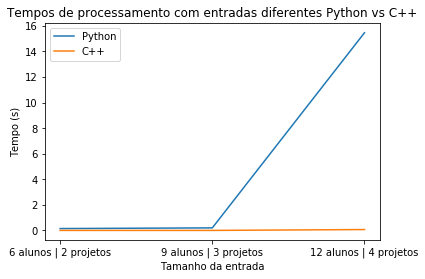

In [14]:
#C++ vs Python
start_time = time.time()
subprocess.run("python3 backtrack.py < entrada1", shell=True)
time1_py = (time.time() - start_time)
start_time = time.time()
subprocess.run("build/busca_exaustiva_seq < entrada1", shell=True)
time1_cpp = (time.time() - start_time)

start_time = time.time()
subprocess.run("python3 backtrack.py < entrada2", shell=True)
time2_py = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_exaustiva_seq < entrada2", shell=True)
time2_cpp = (time.time() - start_time)

start_time = time.time()
subprocess.run("python3 backtrack.py < entrada3", shell=True)
time3_py = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_exaustiva_seq < entrada3", shell=True)
time3_cpp = (time.time() - start_time)

tempos_py = [time1_py, time2_py, time3_py]
tempos_cpp = [time1_cpp, time2_cpp, time3_cpp]
entradas = ["6 alunos | 2 projetos", "9 alunos | 3 projetos" , "12 alunos | 4 projetos"]
plt.plot(entradas, tempos_py, label='Python')
plt.plot(entradas, tempos_cpp, label='C++')
plt.title('Tempos de processamento com entradas diferentes Python vs C++')
plt.ylabel('Tempo (s)')
plt.xlabel('Tamanho da entrada')
plt.legend(loc='best')
plt.show()

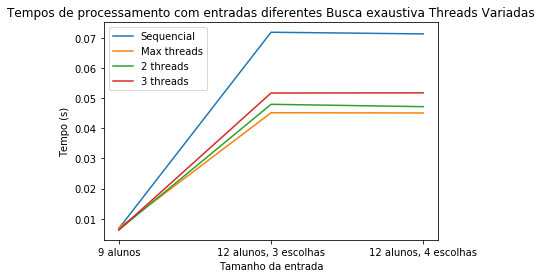

In [15]:
#Busca exaustiva varias threads
start_time = time.time()
subprocess.run("build/busca_exaustiva_seq < projeto-validacao/entradas/in_exaustivo_9_3_3", shell=True)
time1_seq = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_9_3_3", shell=True)
time1_par = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=2 build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_9_3_3", shell=True)
time1_par2 = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=3 build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_9_3_3", shell=True)
time1_par3 = (time.time() - start_time)



start_time = time.time()
subprocess.run("build/busca_exaustiva_seq < projeto-validacao/entradas/in_exaustivo_12_4_3", shell=True)
time2_seq = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_12_4_3", shell=True)
time2_par = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=2 build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_12_4_3", shell=True)
time2_par2 = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=3 build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_12_4_3", shell=True)
time2_par3 = (time.time() - start_time)



start_time = time.time()
subprocess.run("build/busca_exaustiva_seq < projeto-validacao/entradas/in_exaustivo_12_4_4", shell=True)
time3_seq = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_12_4_4", shell=True)
time3_par = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=2 build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_12_4_4", shell=True)
time3_par2 = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=3 build/busca_exaustiva_par < projeto-validacao/entradas/in_exaustivo_12_4_4", shell=True)
time3_par3 = (time.time() - start_time)


tempos_seq = [time1_seq, time2_seq, time3_seq]
tempos_par = [time1_par, time2_par, time3_par]
tempos_par2 = [time1_par2, time2_par2, time3_par2]
tempos_par3 = [time1_par3, time2_par3, time3_par3]


entradas = ["9 alunos", "12 alunos, 3 escolhas" , "12 alunos, 4 escolhas"]
plt.plot(entradas,tempos_seq,label='Sequencial')
plt.plot(entradas,tempos_par,label="Max threads")
plt.plot(entradas,tempos_par2,label="2 threads")
plt.plot(entradas,tempos_par3,label="3 threads")
plt.title('Tempos de processamento com entradas diferentes Busca exaustiva Threads Variadas')
plt.ylabel('Tempo (s)')
plt.xlabel('Tamanho da entrada')
plt.legend(loc='best')
plt.show()

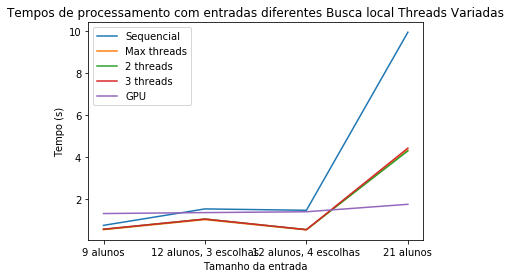

In [17]:
#Busca local varias threads
start_time = time.time()
subprocess.run("build/busca_local_seq < projeto-validacao/entradas/in_local_9_3_3", shell=True)
time1_seq = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_local_par < projeto-validacao/entradas/in_local_9_3_3", shell=True)
time1_par = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=2 build/busca_local_par < projeto-validacao/entradas/in_local_9_3_3", shell=True)
time1_par2 = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=3 build/busca_local_par < projeto-validacao/entradas/in_local_9_3_3", shell=True)
time1_par3 = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_gpu < projeto-validacao/entradas/in_local_9_3_3", shell=True)
time1_gpu = (time.time() - start_time)


start_time = time.time()
subprocess.run("build/busca_local_seq < projeto-validacao/entradas/in_local_12_4_3", shell=True)
time2_seq = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_local_par < projeto-validacao/entradas/in_local_12_4_3", shell=True)
time2_par = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=2 build/busca_local_par < projeto-validacao/entradas/in_local_12_4_3", shell=True)
time2_par2 = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=3 build/busca_local_par < projeto-validacao/entradas/in_local_12_4_3", shell=True)
time2_par3 = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_gpu < projeto-validacao/entradas/in_local_12_4_3", shell=True)
time2_gpu = (time.time() - start_time)


start_time = time.time()
subprocess.run("build/busca_local_seq < projeto-validacao/entradas/in_local_12_4_4", shell=True)
time3_seq = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_local_par < projeto-validacao/entradas/in_local_12_4_4", shell=True)
time3_par = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=2 build/busca_local_par < projeto-validacao/entradas/in_local_12_4_4", shell=True)
time3_par2 = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=3 build/busca_local_par < projeto-validacao/entradas/in_local_12_4_4", shell=True)
time3_par3 = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_gpu < projeto-validacao/entradas/in_local_12_4_4", shell=True)
time3_gpu = (time.time() - start_time)



start_time = time.time()
subprocess.run("build/busca_local_seq < projeto-validacao/entradas/in_local_21_8_5", shell=True)
time4_seq = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_local_par < projeto-validacao/entradas/in_local_21_8_5", shell=True)
time4_par = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=2 build/busca_local_par < projeto-validacao/entradas/in_local_21_8_5", shell=True)
time4_par2 = (time.time() - start_time)

start_time = time.time()
subprocess.run("OMP_NUM_THREADS=3 build/busca_local_par < projeto-validacao/entradas/in_local_21_8_5", shell=True)
time4_par3 = (time.time() - start_time)

start_time = time.time()
subprocess.run("build/busca_gpu < projeto-validacao/entradas/in_local_21_8_5", shell=True)
time4_gpu = (time.time() - start_time)


tempos_seq = [time1_seq, time2_seq, time3_seq, time4_seq]
tempos_par = [time1_par, time2_par, time3_par, time4_par]
tempos_par2 = [time1_par2, time2_par2, time3_par2, time4_par2]
tempos_par3 = [time1_par3, time2_par3, time3_par3, time4_par3]
tempos_gpu = [time1_gpu, time2_gpu, time3_gpu, time4_gpu]

entradas = ["9 alunos", "12 alunos, 3 escolhas" , "12 alunos, 4 escolhas", "21 alunos"]
plt.plot(entradas,tempos_seq,label="Sequencial")
plt.plot(entradas,tempos_par,label="Max threads")
plt.plot(entradas,tempos_par2,label="2 threads")
plt.plot(entradas,tempos_par3,label="3 threads")
plt.plot(entradas,tempos_gpu,label="GPU")
plt.title('Tempos de processamento com entradas diferentes Busca local Threads Variadas')
plt.ylabel('Tempo (s)')
plt.xlabel('Tamanho da entrada')
plt.legend(loc='best')
plt.show()

## Resultados
Observando os resultados é possível afirmar que a mudança de python para C++ proporcionou uma melhora substancial na velocidade em quando os tamanhos de entradas fornecidas eram maiores, onde se viu uma melhora de quase 10 vezes na velocidade de processamento.

Os resultados da paralelização da solução exaustiva mostraram o esperado. Isso significa que o tempo de execução dos programas foi menor para uma maior quantidade de threads disponiveis e o desempenho da solução sequencial foi totalmente superado pelo desempenho das solucões paralelas, vendo uma melhora de quase 2 vezes no tempo de processamento para a maior entrada.

Assim como a sulução exaustiva, a solução de busca local apresentou o resultado esperado. Ou seja, quanto mais threads disponíveis, mais rápido o programa irá rodar devido à paralelização, principalmente para entradas maiores.
Alémm disso, a gpu apresentou um desempenho muito superior em relação à solucao paralelizada em CPU, apenas sendo mais lenta para a menor entrada possível. Isso nos revela uma vantagem muito relevante da GPU para entradas grandes, mas uma desvantagem para programas de entradas pequenas.


## Considerações finais
Com os resultados esperados, é possivel concluir que a paralelização de programas é sempre mais vantajosa quando é necessário um grande volume de processamento de dados concorrentes de forma eficiente, em relação ao processamento sequencial. E além disso, para problemas que exigem a paralelização, a solução encontrada pode ser implementada em GPU, caso seja possível dividir essas tarefas de forma independente, e assim obter uma grande melhora no tempo de processamento.